# Homework 3 - pt 1 - Object Detectors

This homework is a continuation of the seminar. You need first to complete all the gaps that were completed on the seminar, and then do the homework part.

# Seminar part

Today is a good day to learn how to implement your own object detector!

Being honest, modern object detectors are still be very complicated systems with a lot of important tricks which help neural network to perform better. So the best strategy for obj detector implementation is to take a good open-source implementation as a basis and incrementally refactor it.

However all implementations have some common things in it. The goal of the current seminar is to learn that things.

In [10]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [11]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


## 1. Pascal VOC 2012

20 classes, 5717 images in train, 5823 images in validation.

[[homepage]](http://host.robots.ox.ac.uk/pascal/VOC/)

In [12]:
CLASSES = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )
LABEL_TO_CLASS_INDEX = {k:i for i,k in enumerate(CLASSES)}
CLASS_INDEX_TO_LABEL = {i:k for i,k in enumerate(CLASSES)}

In [13]:
means = np.array([0.45704785, 0.43824798, 0.40617362], dtype=np.float32)
stds = np.array([0.23908612, 0.23509602, 0.2397311 ], dtype=np.float32)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

def transform_targets(targets):
    targets = targets['annotation']
    objects = targets['object']
    classes = [LABEL_TO_CLASS_INDEX[elem['name']] for elem in objects]
    objects = [[int(elem['bndbox']['xmin']), int(elem['bndbox']['ymin']), 
                int(elem['bndbox']['xmax']), int(elem['bndbox']['ymax'])] for elem in objects]
    sizes = [(elem[2] - elem[0]) * (elem[3] - elem[1]) for elem in objects]
    order = np.argsort(sizes)[::-1]
    objects = np.array(objects, np.int32)[order]
    classes = np.array(classes, np.int32)[order]
    return {'xyxy': torch.from_numpy(objects), 
            'classes': torch.from_numpy(classes)}

MIN_HEIGHT = 512
MIN_WIDTH = 512
def transforms_train(images, targets):
    targets = transform_targets(targets)
    images = transform_train(images)
    images = pad_to_size(images, MIN_HEIGHT, MIN_WIDTH)
    return images, targets

def pad_to_size(images, min_height, min_width):
    if images.shape[1] < min_height:
        images = torchvision.transforms.functional.pad(images, (0,0,0,min_height-images.shape[1]))
    if images.shape[2] < min_width:
        images = torchvision.transforms.functional.pad(images, (0,0, min_width - images.shape[2], 0))
    return images
        
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

def transforms_test(images, targets):
    targets = transform_targets(targets)
    images = transform_test(images)
    images = pad_to_size(images, MIN_HEIGHT, MIN_WIDTH)
    return images, targets

In [16]:
from torchvision.datasets import VOCDetection
train_loader = VOCDetection(root="./voc_data/", download=True, image_set='train', transforms=transforms_train)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=1,
                                              shuffle=True,
                                              num_workers=12)
val_loader = VOCDetection(root="./voc_data/", download=True, image_set='val', transforms=transforms_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=12)


Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data/
Using downloaded and verified file: ./voc_data/VOCtrainval_11-May-2012.tar
Extracting ./voc_data/VOCtrainval_11-May-2012.tar to ./voc_data/


In [20]:
y

{'xyxy': tensor([[[122,   7, 372, 375],
          [211, 147, 325, 255]]], dtype=torch.int32),
 'classes': tensor([[15, 12]], dtype=torch.int32)}

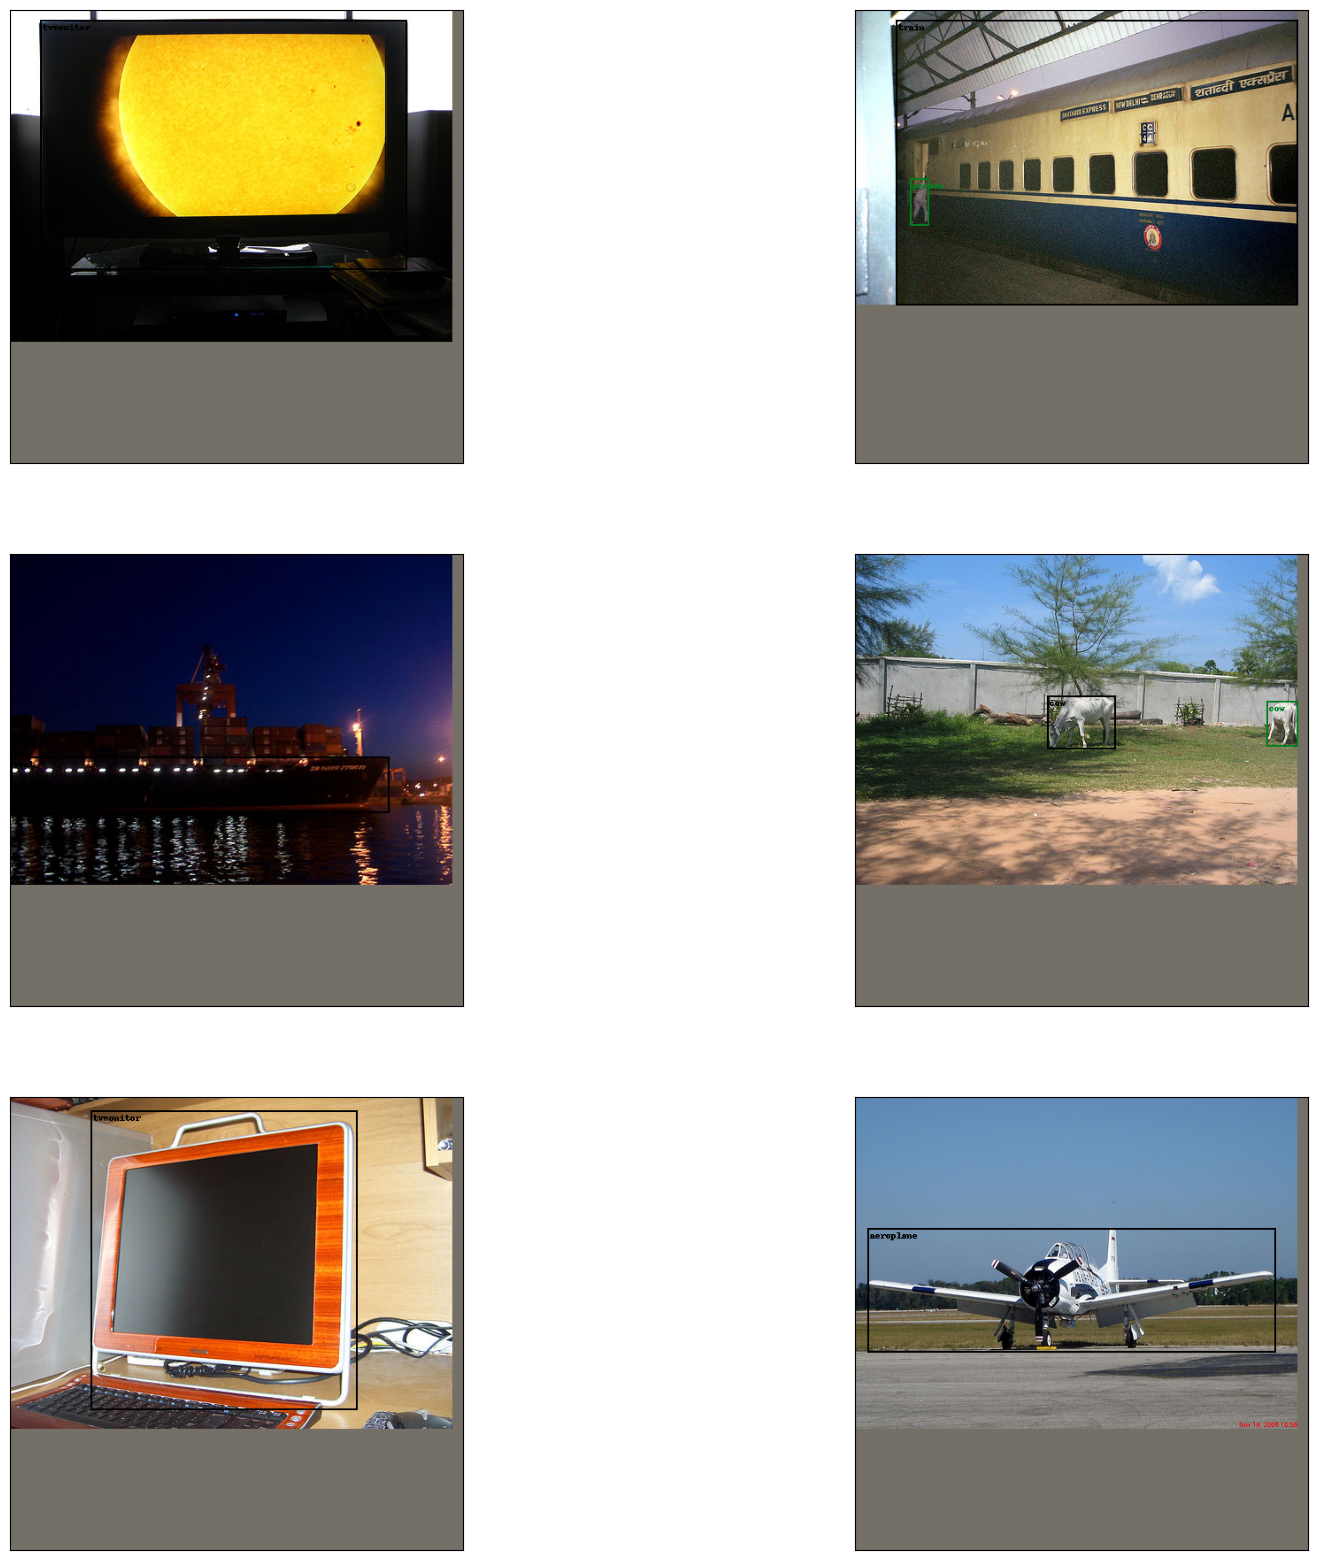

In [17]:
n_images = 6
plt.figure(figsize=(20, 20))
plt.tight_layout()
for i, (x,y) in enumerate(val_batch_gen):
    if i == n_images:
        break
    plt.subplot(3, n_images // 3, i+1)
    img = x[0]*stds.reshape(3,1,1) + means.reshape(3,1,1)
    img = img*255
    img = img.type(torch.uint8)
    labels = [CLASS_INDEX_TO_LABEL[ind.numpy().tolist()] for ind in y['classes'][0]]
    img = torchvision.utils.draw_bounding_boxes(img, y['xyxy'][0], width=2, labels=labels)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.xticks([]); plt.yticks([])

## 2. FCOS - Fully Convolutional One-Stage Object Detector

[paper](https://arxiv.org/pdf/1904.01355v5.pdf)

### 2.1 Architecture

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_3.34.09_PM_SAg1OBo.png" style="width:80%">

Let's implement our detector on the top of resnet18.

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [ ]:
resnet18

In [ ]:
N_SCALES = 5
N_HEAD_LAYERS = 4

    

class RegressionHead(torch.nn.Module):
    def __init__(self, n_head_layers, n_features):
        super().__init__()
        
        # YOUR CODE: sequential with n_head_layers Conv2d(3x3 with padding) + relu
        self.layers = torch.nn.Sequential(...)
        
        self.final_conv = torch.nn.Conv2d(n_features, 4, kernel_size=1)
        
    def forward(self, x):
        x = self.layers(x)
        
        x = self.final_conv(x)
        return x

    
class ClassificationHead(torch.nn.Module):
    def __init__(self, n_head_layers, n_features, n_classes):
        super().__init__()
        # YOUR CODE: same story, sequential but with two final heads
        self.layers = torch.nn.Sequential(...)
            
        self.cls_pred = torch.nn.Conv2d(n_features, n_classes, kernel_size=1)
        self.centerness_pred = torch.nn.Conv2d(n_features, 1, kernel_size=1)
        
        # YOUR CODE: init self.cls_pred.bias with constant b so that sigmoid(b) = 0.01
        init_prob = 0.01  # for focal loss
        
        torch.nn.init.constant_(self.cls_pred.bias, ...)
        
    def forward(self, x):
        x = self.layers(x)
        cls = self.cls_pred(x)
        centerness = self.centerness_pred(x)
        return cls, centerness

    
class FCOS(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.resnet18.train(False)
        n_features = 256
        
        self.conv_p5 = torch.nn.Conv2d(512, n_features, kernel_size=(1,1))
        self.conv_p6 = torch.nn.Conv2d(n_features, n_features, kernel_size=(3,3), stride=2, padding=1)
        self.conv_p7 = torch.nn.Conv2d(n_features, n_features, kernel_size=(3,3), stride=2, padding=1)
        self.conv_p4 = torch.nn.Conv2d(256, n_features, kernel_size=(1,1))
        self.conv_p3 = torch.nn.Conv2d(128, n_features, kernel_size=(1,1))
        
        self.refinement_conv_p3 = torch.nn.Conv2d(n_features, n_features, kernel_size=(1,1))
        self.refinement_conv_p4 = torch.nn.Conv2d(n_features, n_features, kernel_size=(1,1))
        self.refinement_conv_p5 = torch.nn.Conv2d(n_features, n_features, kernel_size=(1,1))
        self.refinement_conv_p6 = torch.nn.Conv2d(n_features, n_features, kernel_size=(1,1))
        self.refinement_conv_p7 = torch.nn.Conv2d(n_features, n_features, kernel_size=(1,1))
        self.refinement_convs = [self.refinement_conv_p3, self.refinement_conv_p4, self.refinement_conv_p5, 
                                 self.refinement_conv_p6, self.refinement_conv_p7]
                                
        self.cls_head = ClassificationHead(N_HEAD_LAYERS, n_features, n_classes)
        self.reg_head = RegressionHead(N_HEAD_LAYERS, n_features)
        
        self.regression_scales = torch.nn.Parameter(torch.ones(len(self.refinement_convs), dtype=torch.float32))
        
    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        c2 = self.resnet18.layer1(x)
        c3 = self.resnet18.layer2(c2)
        c4 = self.resnet18.layer3(c3)
        c5 = self.resnet18.layer4(c4)
        # don't compute avgpool+flatten+fc in resnet
        
        # YOUR CODE
        p5 = self.conv_p5(c5)
        p6 = ...
        p7 = ...
        p4 = self.conv_p4(c4) + F.interpolate(p5, size=c4.shape[2:], mode='nearest')
        p3 = ...
        
        cls_results = []
        reg_results = []
        centerness_results = []
        for i, scale_features in enumerate([p3, p4, p5, p6, p7]):
            # YOUR CODE apply refinement_convs and heads
            refined_features = ...
            cls, centerness = ...
            reg = self.reg_head(refined_features) * self.regression_scales[i]
            cls_results.append(cls)
            reg_results.append(reg)
            centerness_results.append(centerness)
        return cls_results, reg_results, centerness_results


In [ ]:
detector = FCOS(n_classes=20)

In [ ]:
pred = detector(x)

### 2.2 Assignment and targets

In FCOS in each pixel we predict box class label, distances to left, right, top and bottom borders of box object and centerness heatmap.

<img src="https://miro.medium.com/max/225/1*8Ou4qNoKscReoOzMQJ1ZYA.png">

It all starts with assignment of gt boxes to the pixels of sourse images. 

Here is a quote from the paper about assignment procedure:

> More specifically, we firstly compute the regression targets $(l^∗, t^∗, r^∗, b^∗)$ for each location on all feature levels.  
> Next,  if a location satisfies $\max(l^∗, t^∗, r^∗, b^∗) > m_i$ or $\max(l^∗, t^∗, r^∗, b^∗) < m_{i−1}$, it is set as a negative sample and is thus not required to regress a bounding box anymore.  
> Here $m_i$ is the maximum distance that feature level $i$ needs to regress. In this work $m_2$,$m_3$,$m_4$,$m_5$,$m_6$ and $m_7$ are set as 0, 64, 128, 256, 512 and $\inf$, respectively. 
> Since objects with different sizes are assigned to different feature levels and most overlapping happens between objects with considerably different sizes. 

> If a location is still assigned to more than one ground truth boxes, we simply choose the ground truth box with minimal area as its target. 

Once assignment is done, we compute regression and centerness targets for pixels assigned to some box. Regression targets definition is straight forward: for each pixel it's the distance from the pixel to boundaries.

Centerness is defined by specific formula:
$$\text{centerness} = \sqrt{\frac{\min(l^*, r^*)}{\max(l^*,r^*)} \times \frac{\min(t^*, b^*)}{\max(t^*,b^*)}}$$

In [ ]:
def calc_centerness(scale_regression):
    """
    scale_regression - tensor of shape [bs, n_boxes, 4] in form of xyxy
    """
    # YOUR CODE don't forget to fix div by zero
    scale_centerness = torch.sqrt(...)
    return scale_centerness
    
    
def calc_regression_targets(object_xyxy, object_xyxy_at_scale, scale_stride):
    x_min, y_min, x_max, y_max = torch.unbind(object_xyxy_at_scale)
    center_points = torch.meshgrid(torch.arange(y_min, y_max), torch.arange(x_min, x_max))[::-1]
    center_points = torch.stack(center_points, axis=-1)
    center_points = center_points.type(torch.float32) * scale_stride + scale_stride / 2
    
    # YOUR CODE 
    left_top_shift = ...
    right_bottom_shift = ...
    result = torch.cat((left_top_shift, right_bottom_shift), axis=-1)
    return result
    
    
def get_heads_gt(targets, shapes, strides):
    n = len(targets['classes'][0])
    gt_classes = []
    gt_centerness = []
    gt_regression = []
    n_scales = len(shapes)
    REGRESSION_BOUNDS = [0, 64, 128, 256, 512, 1e5]
    
    for i in range(n_scales):
        h, w = shapes[i][2], shapes[i][3]
        scale_stride = strides[i]
        
        scale_classes = torch.zeros([h, w], dtype=torch.int32)
        scale_regression = torch.zeros([h,w,4], dtype=torch.float32)
        
        for j in range(n):
            object_xyxy = targets['xyxy'][0, j]
            object_xyxy_at_scale = torch.round(object_xyxy / scale_stride).type(torch.int32)
            x_min, y_min, x_max, y_max = torch.unbind(object_xyxy_at_scale)
            if x_min >= x_max or y_min >= y_max:
                continue
            regression_targets = calc_regression_targets(object_xyxy, object_xyxy_at_scale, scale_stride)
            max_regression_targets = regression_targets.max(axis=-1)[0]
            mask = torch.logical_and(max_regression_targets >= REGRESSION_BOUNDS[i],
                                     max_regression_targets <= REGRESSION_BOUNDS[i+1])
            #mask = torch.ones_like(mask)
            scale_classes[y_min:y_max, x_min:x_max] = torch.where(
                mask, targets['classes'][0, j], scale_classes[y_min:y_max, x_min:x_max])
            scale_regression[y_min:y_max, x_min:x_max] = torch.where(
                mask[:,:,np.newaxis], regression_targets, scale_regression[y_min:y_max, x_min:x_max])
            
        scale_centerness = calc_centerness(scale_regression)
        gt_classes.append(scale_classes[np.newaxis, np.newaxis])
        gt_centerness.append(scale_centerness[np.newaxis, np.newaxis])
        gt_regression.append(scale_regression.permute(2,0,1)[np.newaxis])
    return gt_classes, gt_regression, gt_centerness
            

In [ ]:
gt = get_heads_gt(y, [elem.shape for elem in pred[0]], [2**i for i in range(3, 7+1)])

Let's visualize the targets

In [ ]:
def get_img(x):
    return x.numpy().transpose(1,2,0)*stds + means

In [ ]:
plt.figure(figsize=(15,10))
plt.tight_layout()
n_scales = len(pred[0])
plt.subplot(6,1+n_scales,1)
plt.imshow(get_img(x[0]))
for i in range(n_scales):
    # classes
    plt.subplot(6,1+n_scales, i+2)
    plt.imshow(gt[0][i][0, 0].numpy())
    # centerness
    plt.subplot(6,1+n_scales, (1+n_scales) + i+2)
    plt.imshow(gt[2][i][0, 0].numpy())
    # regressions
    for j in range(4):
        plt.subplot(6,1+n_scales, (1+n_scales)*(2+j) + i+2)
        plt.imshow(gt[1][i][0, j].numpy())
print(y)

In [ ]:
def decode_boxes(offsets, positive_mask, stride):
    ys, xs = torch.where(positive_mask)
    xs = xs * stride + stride / 2
    ys = ys * stride + stride / 2
    offsets = offsets.permute(1,2,0)[positive_mask]
    x_min = xs - offsets[:,0]
    y_min = ys - offsets[:,1]
    x_max = xs + offsets[:,2]
    y_max = ys + offsets[:,3]
    return torch.stack([x_min, y_min, x_max, y_max], axis=-1)

In [ ]:
gt_cls, gt_reg, gt_centerness = gt

print('gt_boxes:')
print(y['xyxy'].numpy())
for i in range(len(gt_cls)):
    mask = gt_cls[i]>0
    stride = 2**(i+3)
    a = decode_boxes(gt_reg[i][0], mask[0,0], stride)
    print(f'boxes from scale {i}')
    print(a.numpy())

Any ideas, what to do with multiple possible predictions on gt instances?

## Homework part

### 2.3 Losses (3 points)

In this part you need to fill the gaps in code for losses computation.

Classification loss is so called focal loss ([paper](https://arxiv.org/pdf/1708.02002.pdf)):

$$\text{FL}(p_t) = -(1-p_t)^\gamma \log p_t$$

where $p_t = \text{sigmoid}(x)$ for positive class and $p_t = 1- \text{sigmoid}(x) = \text{sigmoid}(-x)$ otherwise. 

For focal loss it's important to provide correct initialization of biases in the final layer that predicts logits.

In [ ]:
gt_cls, gt_reg, gt_centerness = gt
pred_cls, pred_reg, pred_centerness = pred

In [ ]:
def calc_focal_loss(pred, gt, alpha=0.25, gamma=2.):
    """
    pred - tensor of shape [bs, n_classes, h, w]
    gt - tensor of shape [bs, 1, h, w] with elements in [0... n_classes+1]
    """
    bs, n_classes, h, w = pred.shape
    one_hot = torch.zeros((bs, n_classes+1, h, w), dtype=torch.float32)
    gt = gt.type(torch.int64)
    one_hot.scatter_(dim=1, index=gt, src=torch.ones_like(gt, dtype=torch.float32))
    one_hot = one_hot[:,1:]  # remove negative class

    # YOUR CODE
    p = ...
    pt = ...
    log_pt = ...

    return torch.sum(-alpha * (1-pt)**gamma * log_pt)

In [ ]:
for i in range(len(pred_cls)):
    print(calc_focal_loss(pred_cls[i], gt_cls[i]))

Loss for centerness is binary cross entropy

In [ ]:
def calc_centerness_loss(pred, gt):
    return torch.sum(-gt*F.logsigmoid(pred))

In [ ]:
for i in range(len(pred_cls)):
    mask = gt_cls[i]>0
    if torch.any(mask):
        loss = calc_centerness_loss(pred_centerness[i][mask], gt_centerness[i][mask])
    else:
        loss = 0.0
    print(loss)

Generalized IoU for regression ([paper](https://giou.stanford.edu/GIoU.pdf))
<img src="https://miro.medium.com/max/1400/1*AO24IoYBsnneViLzEqrS0A.png" style="width:40%">

Any ideas, why do we need object `C` here?

In [ ]:
def calc_giou_loss(x, y):
    '''
    x - [n_boxes, 4], xyxy format
    y - [n_boxes, 4], xyxy format
    '''
    x_area = (x[:,2] - x[:,0]) * (x[:,3] - x[:,1])
    y_area = (y[:,2] - y[:,0]) * (y[:,3] - y[:,1])

    intersection_start = torch.maximum(x[:,:2], y[:,:2])
    intersection_end = torch.minimum(x[:,2:], y[:,2:])
    intersection_wh = (intersection_end - intersection_start).clip(min=0)
    intersection_area = intersection_wh[:, 0] * intersection_wh[:,1]
    
    union_area = x_area + y_area - intersection_area
    iou = intersection_area / union_area

    # YOUR CODE: box for C
    enclosing_box_start = ...
    enclosing_box_end = ...
    enclosing_box_wh = ...
    enclosing_box_area = ...

    giou_value = iou - (enclosing_box_area-union_area) / enclosing_box_area

    giou_loss = 1. - giou_value
    return torch.sum(giou_loss)

In [ ]:
for i in range(len(pred_cls)):
    mask = gt_cls[i]>0
    if torch.any(mask):
        stride = 2**(i+3)
        decoded_boxes_pred = decode_boxes(torch.exp(pred_reg[i][0]), mask[0,0], stride)
        decoded_boxes_gt = decode_boxes(gt_reg[i][0], mask[0,0], stride)
        loss = calc_giou_loss(decoded_boxes_pred, decoded_boxes_gt)
    else:
        loss = 0.0
    print(loss)

Combining all together

In [ ]:
def compute_loss(pred, gt):
    gt_cls, gt_reg, gt_centerness = gt
    pred_cls, pred_reg, pred_centerness = pred

    n_scales = len(pred)
    cl_loss = 0.0
    reg_loss = 0.0
    cent_loss = 0.0
    n_positive = 0
    for i in range(n_scales):
        cl_loss += calc_focal_loss(pred_cls[i].cpu(), gt_cls[i])
        
        mask = gt_cls[i]>0
        n_positive += torch.sum(mask)
        if torch.any(mask):
            cent_loss += calc_centerness_loss(pred_centerness[i].cpu()[mask], gt_centerness[i][mask])
        
            stride = 2**(i+3)
            decoded_boxes_pred = decode_boxes(torch.exp(pred_reg[i].cpu()[0]), mask[0,0], stride)
            decoded_boxes_gt = decode_boxes(gt_reg[i][0], mask[0,0], stride)
            reg_loss += calc_giou_loss(decoded_boxes_pred, decoded_boxes_gt)
            
    n_positive = n_positive.clip(20)
    cl_loss = cl_loss / n_positive
    reg_loss = reg_loss / n_positive
    cent_loss = cent_loss / n_positive
    total_loss = cl_loss + reg_loss + cent_loss
    return total_loss, (cl_loss, reg_loss, cent_loss)

In [ ]:
compute_loss(pred, gt)

## 3. Training

Now you need to train a model. The code for it is written, although you are welcome to change it as you wish to achieve better results.

To get better results you may change the code above, if you want (including image preprocessing)

Reference: if everything above is right, you should get validation loss <=0.6.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

detector = FCOS(n_classes=20)
detector = detector.to(device)

opt = torch.optim.Adam(detector.parameters(), lr=1e-4, weight_decay=1e-5)
batch_size = 16

In [ ]:
import time
num_epochs = 100
detector.train(False)   # disable batchnorms in resnet

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = []
    val_loss = []
    train_comp_loss = []
    val_comp_loss = []
    
    opt.zero_grad()
    
    for batch_index, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_batch_gen)):
        X_batch = X_batch.to(device)
        
        pred = detector(X_batch)
        gt = get_heads_gt(y_batch, [elem.shape for elem in pred[0]], [2**i for i in range(3, 7+1)])

        loss, component_loss = compute_loss(pred, gt)
        loss = loss / batch_size
        loss.backward()
        if batch_index % batch_size == 0:
            # TODO: check if clipping is needed and adjust parameter
            # clip_value = 1
            # nn.utils.clip_grad_norm(detector.parameters(), clip_value)
            opt.step()
            opt.zero_grad()

        train_loss.append(loss.data.numpy())
        train_comp_loss.append(np.array([elem.data.numpy() for elem in component_loss]))
        print(y_batch, component_loss)
        if batch_index % 250 == 0:
            print("current training loss: \t{:.6f} , \t component loss: {}".format(
                  np.mean(train_loss), np.mean(np.stack(train_comp_loss), axis=0)))
        
    for X_batch, y_batch in val_batch_gen:
        X_batch = X_batch.to(device)

        pred = detector(X_batch)
        gt = get_heads_gt(y_batch, [elem.shape for elem in pred[0]], [2**i for i in range(3, 7+1)])

        loss, component_loss = compute_loss(pred, gt)
        val_loss.append(loss.data.numpy())
        val_comp_loss.append(np.array([elem.data.numpy() for elem in component_loss]))
        
        if len(val_comp_loss) % 100 == 0:
            print("current validation loss: \t{:.2f} , \t componnet loss: {}".format(
                  np.mean(val_loss), np.mean(np.stack(val_comp_loss), axis=0)))

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f} , \t component loss: {}".format(
        np.mean(train_loss), np.mean(np.stack(train_comp_loss), axis=0)))
    print("  validation loss: \t\t\t{:.2f} , \t\t componnet loss: {}".format(
        np.mean(val_loss), np.mean(np.stack(val_comp_loss), axis=0)))

## 4. Inference stuff (7 points)

Here you'll need to complete the code for inference and metric computation.

We'll use MAP for a metric. There's library `torchmetrics`  which provides a function to compute MAP (and other metrics). This library needs to be installed.

In [ ]:
! pip install torchmetrics[detection]

In [ ]:
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
detector = torch.load("model_7_epoch.pt", map_location='cpu')

#### Running inference on images

Your tasks here are:
1. Add centerness scores to the computation of mask. 

Here's the line from the paper about how centerness is used:
``
When testing, the final score (used for ranking the detected bounding boxes) is computed by multiplying the predicted center-ness with the corresponding classification score. Thus the center-ness can downweight the scores of bounding boxes far from the center of an object. As a result, with high probability, these low-quality bounding boxes might be filtered out by the final non-maximum suppression (NMS) process, improving the detection performance remarkably.
``

2. Choose the hyperparameter thrs for mask computation. Actually this hyperparameter should be estimated using train and val sets, but here we won't ask to do that. Simply choose the value that suits you. Although you might write the code for proper parameter estimation =)
3. Add NMS after computing bounding boxes. NMS in PyTorch: `torchvision.ops.nms()`, `torchvision.ops.batched_nms`. Choose the best iou_threshold parameter.
4. Compute average precision metric for the test set and visualize detection results on some images from val data.

To get the full points for this part you need to implement all the parts of the task (1-4) correctly. There are a couple of hints for you to understand that your code is correct:
- correct implementation should achieve map score >= 0.1;
- visually detection results should look acceptable. [Example](https://ibb.co/LPhHHsJ)



In [ ]:
n_images = 12
plt.figure(figsize=(20, 20))
plt.tight_layout()
start = 0

for i, (x,y) in enumerate(val_batch_gen):
    
    x = x.to(device)
    pred_cls, pred_reg, pred_centerness  = detector(x)

    # YOUR CODE HERE
    decoded_boxes = ...

    if i < n_images:
        x = x.cpu()
        plt.subplot(3, n_images // 3, i+1)
        img = x[0]*stds.reshape(3,1,1) + means.reshape(3,1,1)
        img = img*255
        img = img.type(torch.uint8)
        img = torchvision.utils.draw_bounding_boxes(img, decoded_boxes, width=2)
        plt.imshow(img.numpy().transpose(1,2,0))
        plt.xticks([]); plt.yticks([])
